In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras import Sequential, layers, Input, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

In [222]:
df = pd.read_csv('../data/data_clean.csv')
df.head(5)

/var/folders/nj/s1c8f0tj3ksfjdg8xyxr6rdc0000gn/T/ipykernel_73420/2597316256.py:1: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/data_clean.csv')


,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5,codeCPV_2_3,annee,acheteur_tranche_effectif,acheteur_categorie,titulaire_tranche_effectif,titulaire_categorie
0,2154005160001320242024-LOT04,20242024-LOT04,Marché,21540051600013,COMMUNE DE BATILLY,215400516.0,78885470100018,SIRET,ACOMETAL,788854701.0,...,45000000,45200000,45260000,45261000,45200000,2024,12,PME,03,PME
1,243500667002882021M226MO,2021M226MO,Marché,24350066700288,CC VAL D'ILLE-AUBIGNE,243500667.0,38373211200032,SIRET,UNIVERS,383732112.0,...,71000000,71200000,71200000,71200000,71200000,2021,22,PME,03,PME
2,249710047000472024SS_PRD_TRV,2024SS_PRD_TRV,Marché,24971004700047,COMMUNAUTE DE COMMUNES DE MARIE GALANTE,249710047.0,43387249600016,SIRET,COTRAM B.T.P.,433872496.0,...,45000000,45200000,45230000,45232000,45200000,2024,12,PME,12,PME
3,6254801990001124-0806-L2,24-0806-L2,Marché,62548019900011,"LA MAISON POUR TOUS, SOCIETE ANONYME COOPERATI...",625480199.0,55204695502544,SIRET,ENGIE ENERGIE SERVICES,552046955.0,...,50000000,50700000,50720000,50720000,50000000,2024,22,ETI,53,GE
4,20002563300013202424011BCR,202424011BCR,Marché,20002563300013,SI DE RESTAURATION COLLECTIVE,200025633.0,47698032100238,SIRET,POMONA EPISAVEURS,476980321.0,...,15000000,15800000,15800000,15800000,15000000,2024,12,PME,42,GE


In [223]:
from scripts.data_cleaner import filter_top_cpv_categories

df = filter_top_cpv_categories(df, top_n=150, cpv_column='codeCPV_3')

Filtered from 392 to 150 CPV categories, keeping 279174 rows out of 286850


In [224]:
df['codeCPV_3'].value_counts()

codeCPV_3
45200000    62229
45400000    19048
71200000    17621
45100000    13647
71300000    13462
            ...  
31300000      139
55100000      132
31100000      130
18800000      130
16100000      128
Name: count, Length: 150, dtype: int64

In [225]:
df.drop(df[df['montant'] > 999999].index, inplace=True)
df.shape

(238163, 42)

In [226]:
y = np.log1p(df['montant'])
y.head()

0    11.292279
1    10.882925
4    13.235694
5    11.350889
6    12.044412
Name: montant, dtype: float64

In [227]:
bins = np.linspace(y.min(), y.max(), 10)
bins = np.delete(bins, 1)

#bins = bins[2:]

# Créer les étiquettes correspondantes
labels = list(range(0, len(bins)-1))

# Ajouter la colonne fourchette_de_prix
df['bins'] = pd.cut(y, bins=bins, labels=labels, include_lowest=True, right=True)

df.shape

(238163, 43)

In [228]:
np.exp(bins)

array([  20001.        ,   47708.50133762,   73683.08597334,
        113799.36502582,  175756.69245133,  271446.28561345,
        419233.45817256,  647482.39989405, 1000000.        ])

In [229]:
len(labels)

8

In [230]:
df['bins'] = df['bins'].astype('int')
df = df.drop(columns='montant')
df.columns

Index(['uid', 'id', 'nature', 'acheteur_id', 'acheteur_nom', 'acheteur_siren',
       'titulaire_id', 'titulaire_typeIdentifiant', 'titulaire_nom',
       'titulaire_siren', 'objet', 'codeCPV', 'procedure', 'dureeMois',
       'dateNotification', 'datePublicationDonnees', 'formePrix',
       'attributionAvance', 'offresRecues', 'marcheInnovant', 'ccag',
       'sousTraitanceDeclaree', 'typeGroupementOperateurs', 'tauxAvance',
       'origineUE', 'origineFrance', 'lieuExecution_code',
       'lieuExecution_typeCode', 'idAccordCadre', 'source_open_data',
       'codeCPV_FR', 'codeCPV_2', 'codeCPV_3', 'codeCPV_4', 'codeCPV_5',
       'codeCPV_2_3', 'annee', 'acheteur_tranche_effectif',
       'acheteur_categorie', 'titulaire_tranche_effectif',
       'titulaire_categorie', 'bins'],
      dtype='object')

In [231]:
X = df.drop(columns=['bins', 'titulaire_tranche_effectif', 'titulaire_categorie'])
y = df['bins']

In [232]:
X[['acheteur_tranche_effectif', 'acheteur_categorie']] = X[['acheteur_tranche_effectif', 'acheteur_categorie']].fillna('null')
X[['acheteur_tranche_effectif', 'acheteur_categorie']].isna().sum()

acheteur_tranche_effectif    0
acheteur_categorie           0
dtype: int64

In [233]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=X['codeCPV_3'])

In [236]:
from scripts.preprocess_pipeline import create_pipeline

numerical_columns = ['dureeMois', 'offresRecues', 'annee']

binary_columns = ['sousTraitanceDeclaree', 'origineFrance',
                          'marcheInnovant', 'idAccordCadre']

categorical_columns = ['procedure', 'nature', 'formePrix', 'ccag',
                               'typeGroupementOperateurs', 'tauxAvance_cat',
                               'codeCPV_3', 'acheteur_tranche_effectif', 'acheteur_categorie']

pipeline = create_pipeline(numerical_columns, binary_columns, categorical_columns)

In [238]:
X_train_preproc = pipeline.fit_transform(X_train)
X_train_preproc.shape

(190530, 220)

In [234]:
from keras.utils import to_categorical
y_train_cat = to_categorical(y_train)
y_train_cat.shape

(190530, 8)

In [235]:
y_train_cat.shape

(190530, 8)

In [239]:
def build_mlp_model(input_dim=220, num_classes=8, use_dropout=True, l2_factor=1e-4):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    # Couche 1
    model.add(layers.Dense(
        1028, activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor)
    ))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.4))

    # Couche 2
    model.add(layers.Dense(
        512, activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor)
    ))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.3))

    # Couche 3
    model.add(layers.Dense(
        256, activation='relu',
        kernel_regularizer=regularizers.l2(l2_factor)
    ))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.2))

    # Sortie
    model.add(layers.Dense(
        num_classes, activation='softmax',
        kernel_regularizer=regularizers.l2(l2_factor)
    ))

    # Compilation
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [240]:
model = build_mlp_model()
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 1028)           │       227,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 1028)           │         4,112 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1028)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 512)            │       526,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 894,604 (3.41 MB)

 Trainable params: 891,012 (3.40 MB)

 Non-trainable params: 3,592 (14.03 KB)

In [241]:
es = EarlyStopping(patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-6)


history = model.fit(
        X_train_preproc, y_train_cat,
        validation_split=0.2,
        batch_size=128,
        epochs=150,
        callbacks=[es, lr_scheduler],
        verbose=1)

Epoch 1/150
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.1852 - loss: 2.3052 - val_accuracy: 0.2187 - val_loss: 2.0228 - learning_rate: 0.0010
Epoch 2/150
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2156 - loss: 2.0280 - val_accuracy: 0.2234 - val_loss: 1.9871 - learning_rate: 0.0010
Epoch 3/150
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2228 - loss: 1.9842 - val_accuracy: 0.2247 - val_loss: 1.9642 - learning_rate: 0.0010
Epoch 4/150
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2253 - loss: 1.9624 - val_accuracy: 0.2269 - val_loss: 1.9495 - learning_rate: 0.0010
Epoch 5/150
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.2289 - loss: 1.9477 - val_accuracy: 0.2260 - val_loss: 1.9436 - learning_rate: 0.0010
Epoch 6/150
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.2260 - loss: 1.9437 - val_accuracy: 0.2318 - val_loss: 1.9420 - learning_rate: 0.0010
Epoch 7/150
1191/1191 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.

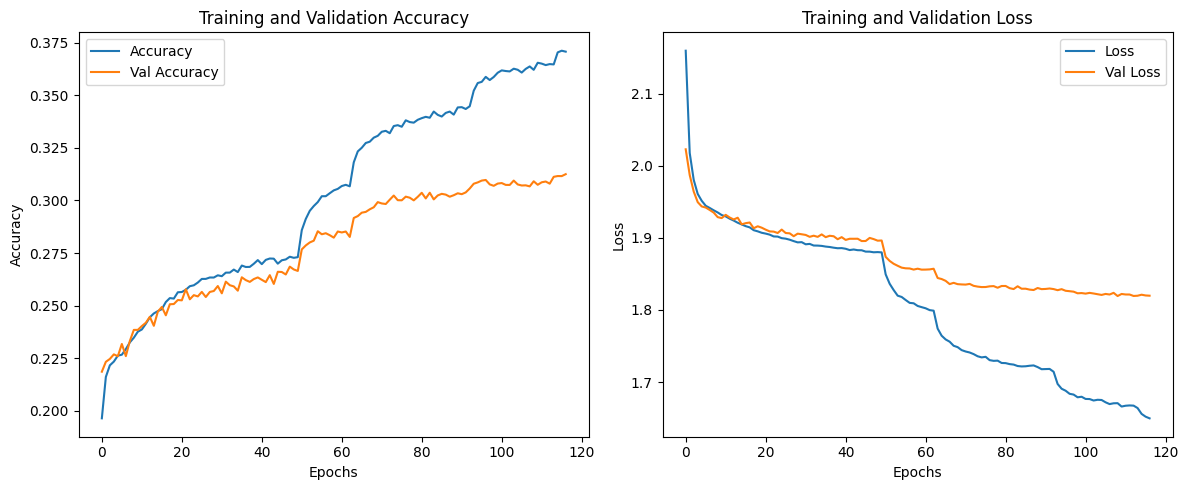

In [242]:
# Récupération des données d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la figure
plt.figure(figsize=(12, 5))

# Plot de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Affichage
plt.tight_layout()
plt.show()

In [243]:
model.save("modele_montant_8.keras")

In [244]:
X_test_preproc = pipeline.transform(X_test)

/Users/paulcolas/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [245]:
y_test_cat = to_categorical(y_test)

In [246]:
print(X_test_preproc.shape)
print(y_test_cat.shape)

(47633, 220)
(47633, 8)


In [247]:
# from keras.models import load_model

# modelf = load_model("model_montant.keras")

In [248]:
y_new = model.predict(X_test_preproc)

1489/1489 ━━━━━━━━━━━━━━━━━━━━ 3s 717us/step


In [249]:
y_new.shape

(47633, 8)

In [201]:
y_new

array([[3.3052803e-09, 6.9938704e-02, 1.2791319e-01, ..., 1.2102299e-01,
        8.9703359e-02, 5.0089445e-02],
       [2.9201761e-09, 1.1350881e-01, 1.9125593e-01, ..., 1.0362364e-01,
        4.1198920e-02, 1.8769527e-02],
       [2.3049219e-10, 6.4743626e-01, 2.8950447e-01, ..., 6.5106491e-04,
        1.9347685e-04, 6.3748863e-05],
       ...,
       [2.5112814e-09, 5.3283103e-02, 2.2706912e-01, ..., 6.7977317e-02,
        3.5313621e-02, 9.8188315e-03],
       [3.0052985e-09, 2.5188228e-02, 5.0490413e-02, ..., 2.2962272e-01,
        1.9361427e-01, 1.1644605e-01],
       [2.9832277e-09, 2.0712699e-01, 3.7025921e-02, ..., 8.9398943e-02,
        5.8743078e-02, 4.0994335e-02]], dtype=float32)

In [250]:
# y_new : array de shape (n_samples, n_classes)
one_hot = np.zeros_like(y_new)
one_hot
one_hot[np.arange(len(y_new)), y_new.argmax(axis=1)] = 1
one_hot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [251]:
y_test_cat.shape

(47633, 8)

In [252]:
model.evaluate(X_test_preproc, y_test_cat)

1489/1489 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3074 - loss: 1.8139


[1.8111323118209839, 0.3100161552429199]

In [253]:
from sklearn.metrics import classification_report

print(classification_report(y_test_cat, one_hot))

              precision    recall  f1-score   support

           0       0.32      0.30      0.31      5554
           1       0.30      0.41      0.35      7815
           2       0.28      0.30      0.29      8080
           3       0.27      0.26      0.27      7051
           4       0.29      0.28      0.29      6810
           5       0.32      0.28      0.30      5117
           6       0.39      0.33      0.36      4172
           7       0.52      0.28      0.36      3034

   micro avg       0.31      0.31      0.31     47633
   macro avg       0.34      0.31      0.32     47633
weighted avg       0.32      0.31      0.31     47633
 samples avg       0.31      0.31      0.31     47633



In [211]:
pd.DataFrame(y_test).value_counts()

bins
3       8080
2       7815
4       7051
5       6810
1       5554
6       5117
7       4172
8       3034
Name: count, dtype: int64

In [175]:
# # Dimensions
# input_dim = 220
# num_classes = 10

# # Modèle MLP
# model = Sequential()

# model.add(Input(shape=(input_dim,)))

# model.add(layers.Dense(1028, activation='relu',))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.4))

# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.3))

# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.3))

# model.add(layers.Dense(num_classes, activation='softmax'))  # Sortie pour classification

# # Compilation
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',  # ou 'categorical_crossentropy' si y est one-hot
#     metrics=['accuracy']
# )

# # Affichage du résumé du modèle
# model.summary()

In [172]:
# es = EarlyStopping(patience=5, restore_best_weights=True, min_delta=1e-3)

# history2 = model.fit(
#         X_train_preproc, y_train_cat,
#         validation_split=0.2,
#         batch_size=32,
#         epochs=100,
#         callbacks=[es],
#         verbose=1)

In [ ]:
# Récupération des données d'entraînement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Création de la figure
plt.figure(figsize=(12, 5))

# Plot de l'accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot de la loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Affichage
plt.tight_layout()
plt.show()

In [173]:
# # Dimensions
# input_dim = 220
# num_classes = 10

# # Modèle MLP
# model = Sequential()

# model.add(Input(shape=(input_dim,)))

# model.add(layers.Dense(1028, activation='relu',))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))

# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.4))

# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.3))

# model.add(layers.Dense(num_classes, activation='softmax'))  # Sortie pour classification

# # Compilation
# model.compile(
#     optimizer='adam',
#     loss='categorical_crossentropy',  # ou 'categorical_crossentropy' si y est one-hot
#     metrics=['accuracy']
# )

# # Affichage du résumé du modèle
# model.summary()

In [ ]:
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history3 = model.fit(
    X_train_preproc, y_train_cat,
    validation_split=0.2,
    batch_size=128,
    epochs=100,
    callbacks=[early_stop, lr_scheduler],
)

In [ ]:
def build_mlp_model(input_dim=220, num_classes=10, use_dropout=True):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))

    model.add(layers.Dense(1028, activation='relu'))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.5))

    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.4))

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    if use_dropout:
        model.add(layers.Dropout(0.3))

    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy'
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_mlp_model(use_dropout=False)

history4 = model.fit(
    X_train_preproc, y_train_cat,
    validation_split=0.2,
    batch_size=128,
    epochs=100,
    callbacks=[early_stop, lr_scheduler],
)

In [ ]:
# # Récupération des données d'entraînement et validation
# acc = history4.history['accuracy']
# val_acc = history4.history['val_accuracy']
# loss = history4.history['loss']
# val_loss = history4.history['val_loss']

# # Création de la figure
# plt.figure(figsize=(12, 5))

# # Plot de l'accuracy
# plt.subplot(1, 2, 1)
# plt.plot(acc, label='Accuracy')
# plt.plot(val_acc, label='Val Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# # Plot de la loss
# plt.subplot(1, 2, 2)
# plt.plot(loss, label='Loss')
# plt.plot(val_loss, label='Val Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# # Affichage
# plt.tight_layout()
# plt.show()

In [171]:
# def build_mlp_model(input_dim=220, num_classes=10, use_dropout=True, l2_factor=1e-4):
#     model = Sequential()
#     model.add(Input(shape=(input_dim,)))

#     # Couche 1
#     model.add(layers.Dense(
#         1028, activation='relu',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))
#     model.add(layers.BatchNormalization())
#     if use_dropout:
#         model.add(layers.Dropout(0.5))

#     # Couche 2
#     model.add(layers.Dense(
#         512, activation='relu',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))
#     model.add(layers.BatchNormalization())
#     if use_dropout:
#         model.add(layers.Dropout(0.4))

#     # Couche 3
#     model.add(layers.Dense(
#         256, activation='relu',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))
#     model.add(layers.BatchNormalization())
#     if use_dropout:
#         model.add(layers.Dropout(0.3))

#     # Sortie
#     model.add(layers.Dense(
#         num_classes, activation='softmax',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))

#     # Compilation
#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

In [169]:
# model = build_mlp_model(use_dropout=False)
# history5 = model.fit(
#     X_train_preproc, y_train_cat,
#     validation_split=0.2,
#     batch_size=128,
#     epochs=100,
#     callbacks=[early_stop, lr_scheduler],
# )

In [170]:
# model = build_mlp_model(use_dropout=True)
# history5 = model.fit(
#     X_train_preproc, y_train_cat,
#     validation_split=0.2,
#     batch_size=128,
#     epochs=100,
#     callbacks=[early_stop, lr_scheduler],
# )

In [168]:
# # Récupération des données d'entraînement et validation
# acc = history5.history['accuracy']
# val_acc = history5.history['val_accuracy']
# loss = history5.history['loss']
# val_loss = history5.history['val_loss']

# # Création de la figure
# plt.figure(figsize=(12, 5))

# # Plot de l'accuracy
# plt.subplot(1, 2, 1)
# plt.plot(acc, label='Accuracy')
# plt.plot(val_acc, label='Val Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# # Plot de la loss
# plt.subplot(1, 2, 2)
# plt.plot(loss, label='Loss')
# plt.plot(val_loss, label='Val Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# # Affichage
# plt.tight_layout()
# plt.show()

In [167]:
# model = build_mlp_model(use_dropout=False)
# history6 = model.fit(
#     X_train_preproc, y_train_cat,
#     validation_split=0.2,
#     batch_size=128,
#     epochs=100,
#     callbacks=[early_stop, lr_scheduler],
# )

In [166]:
# # Récupération des données d'entraînement et validation
# acc = history6.history['accuracy']
# val_acc = history6.history['val_accuracy']
# loss = history6.history['loss']
# val_loss = history6.history['val_loss']

# # Création de la figure
# plt.figure(figsize=(12, 5))

# # Plot de l'accuracy
# plt.subplot(1, 2, 1)
# plt.plot(acc, label='Accuracy')
# plt.plot(val_acc, label='Val Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# # Plot de la loss
# plt.subplot(1, 2, 2)
# plt.plot(loss, label='Loss')
# plt.plot(val_loss, label='Val Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# # Affichage
# plt.tight_layout()

# plt.show()

In [165]:
# def build_mlp_model(input_dim=220, num_classes=9, use_dropout=True, l2_factor=1e-4):
#     model = Sequential()
#     model.add(Input(shape=(input_dim,)))

#     # Couche 1
#     model.add(layers.Dense(
#         1024, activation='relu',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))
#     model.add(layers.BatchNormalization())
#     if use_dropout:
#         model.add(layers.Dropout(0.4))

#     # Couche 2
#     model.add(layers.Dense(
#         512, activation='relu',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))
#     model.add(layers.BatchNormalization())
#     if use_dropout:
#         model.add(layers.Dropout(0.3))

#     # Couche 3
#     model.add(layers.Dense(
#         256, activation='relu',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))
#     model.add(layers.BatchNormalization())
#     if use_dropout:
#         model.add(layers.Dropout(0.2))
#     #couche 4
#     model.add(layers.Dense(
#         128, activation='relu',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))
#     model.add(layers.BatchNormalization())
#     if use_dropout:
#         model.add(layers.Dropout(0.1))

#     # Sortie
#     model.add(layers.Dense(
#         num_classes, activation='softmax',
#         kernel_regularizer=regularizers.l2(l2_factor)
#     ))

#     # Compilation
#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model

In [164]:
# model = build_mlp_model(use_dropout=False)
# history7 = model.fit(
#     X_train_preproc, y_train_cat,
#     validation_split=0.2,
#     batch_size=128,
#     epochs=100,
#     callbacks=[early_stop, lr_scheduler],
# )

In [163]:
# # Récupération des données d'entraînement et validation
# acc = history7.history['accuracy']
# val_acc = history7.history['val_accuracy']
# loss = history7.history['loss']
# val_loss = history7.history['val_loss']

# # Création de la figure
# plt.figure(figsize=(12, 5))

# # Plot de l'accuracy
# plt.subplot(1, 2, 1)
# plt.plot(acc, label='Accuracy')
# plt.plot(val_acc, label='Val Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()

# # Plot de la loss
# plt.subplot(1, 2, 2)
# plt.plot(loss, label='Loss')
# plt.plot(val_loss, label='Val Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
# plt.legend()

# # Affichage
# plt.tight_layout()
# plt.show()